### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

### Решение

$L = L(F(x_i), y_i)$

Таргет $z_i = -\dfrac{\partial L}{\partial F}(F_{k-1}(x_i), y_i)$, $i =\overline{1, n}$ на $k$-й итерации:
1) $z_i = -2(F_{k-1}(x_i) - y_i) = 2(y_i - F_{k-1}(x_i))$

2) $z_i = -\exp(-y_i F_{k-1}(x_i))(-y_i) =  y_i\exp(-y_i F_{k-1}(x_i))$

3) $z_i = \dfrac{y_i\exp(-y_i F_{k-1}(x_i))}{1 + \exp(-y_i F_{k-1}(x_i)} = \dfrac{y_i}{1 + \exp(y_i F_{k-1}(x_i))}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [107]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

import random

import matplotlib.pyplot as plt

In [335]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.base_args = args
        self.base_kwargs = kwargs
        self.base_models = [] # (c_i, f_i, idx_feat)
        self.last_loss = None
        self.last_predict = None
    
    def calc_grad(self, idx_obj, y):
        F_last = self.last_predict[idx_obj]
        if self.loss == 'exp':
            return y * np.exp(-y * F_last)
        elif self.loss == 'logexp':
            tmp = np.exp(y * F_last)
            return y / (1.0 + tmp)
        elif self.loss == 'mse':
            return 2 * (y - F_last)
    
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        n_obj = int(self.subsample * X.shape[0])
        n_feat = int(self.colsample * X.shape[1])
        
        if init_model is not None:
            init_model.fit(X, y)
            self.last_predict = init_model.predict(X).astype('float64')
            self.base_models.append((1.0, init_model, np.arange(X.shape[1])))
        else:
            self.last_predict = np.zeros(shape=(X.shape[0]))
        
        grid = np.indices(X.shape)
        for step in range(self.n_estimators):
            model = base_model(*self.base_args, **self.base_kwargs)
            idx_obj = np.random.choice(X.shape[0], n_obj)
            idx_obj = np.array(range(X.shape[0]))
            idx_feat = np.sort(np.random.choice(X.shape[1], n_feat, replace=False))
            X_sample = X[grid[0][idx_obj, :idx_feat.shape[0]], grid[1][:idx_obj.shape[0], idx_feat]]
            z_sample = self.calc_grad(idx_obj, y[idx_obj])
            model.fit(X_sample, z_sample)
            self.base_models.append((self.learning_rate, model, idx_feat))
            self.last_predict += self.learning_rate * model.predict(X[:, idx_feat])
        
        
    def predict(self, X):
        # Ваш код здесь
        pred = 0
        n_obj = int(self.subsample * X.shape[0])
        n_feat = int(self.colsample * X.shape[1])
        grid = np.indices(X.shape)
        for eta, model, idx_feat in self.base_models:
            X_sample = X[grid[0][:, :idx_feat.shape[0]], grid[1][:, idx_feat]]
            pred += eta * model.predict(X_sample)
        if self.loss == 'mse':
            return (pred + 0.5).astype('int')
        else:
            return -1 + 2 * (pred > 0).astype('int')

In [266]:
my_clf = MyGradientBoostingClassifier(n_estimators=100)
clf = GradientBoostingClassifier()

In [267]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [268]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [269]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
y1 = -1 + 2 * y
print(X.shape, y.shape)

(20640, 8) (20640,)


In [270]:
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
train_len = int(0.6 * X.shape[0])
X_train, X_val = X[idx[:train_len]], X[idx[train_len:]]
y_train, y_val = y[idx[:train_len]], y[idx[train_len:]]
y1_train, y1_val = y1[idx[:train_len]], y1[idx[train_len:]]

In [271]:
res = []
res2 = []
losses = ['mse', 'logexp', 'exp']
for loss in losses:
    my_clf = MyGradientBoostingClassifier(n_estimators=500, max_depth=5, loss=loss)
    if loss == 'mse':
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        res.append(accuracy_score(y_pred=y_pred, y_true=y_val))
    else:
        my_clf.fit(X_train, y1_train)
        y_pred = my_clf.predict(X_val)
        res.append(accuracy_score(y_pred=y_pred, y_true=y1_val))

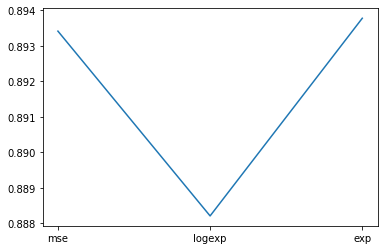

In [272]:
plt.plot(losses, res)

Будем использовать mse и exp loss'ы

In [275]:
res = []
res2 = []
iterations = [5, 10, 15, 20, 30, 40, 50, 100, 150]
for i in iterations:
    my_clf = MyGradientBoostingClassifier(n_estimators=i, max_depth=5, loss='mse')
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_val)
    res.append(accuracy_score(y_pred=y_pred, y_true=y_val))
    
    clf = MyGradientBoostingClassifier(n_estimators=i, max_depth=5, loss='exp')
    clf.fit(X_train, y1_train)
    y_pred = clf.predict(X_val)
    res2.append(accuracy_score(y_pred=y_pred, y_true=y1_val))

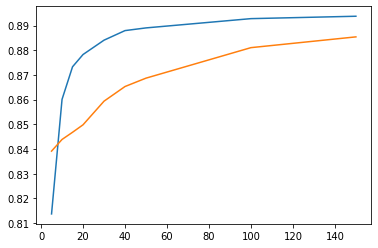

In [276]:
plt.plot(iterations, res)
plt.plot(iterations, res2)

Видим, что оптимальное число итераций равно 100.

Подберем learning_rate.

In [277]:
rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4]
res = []
res2 = []
for l_rate in rates:
    my_clf = MyGradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=l_rate)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_val)
    res.append(accuracy_score(y_pred=y_pred, y_true=y_val))
    
    clf = MyGradientBoostingClassifier(loss = 'exp', n_estimators=100, max_depth=5, learning_rate=l_rate)
    clf.fit(X_train, y1_train)
    y_pred = clf.predict(X_val)
    res2.append(accuracy_score(y_pred=y_pred, y_true=y1_val))

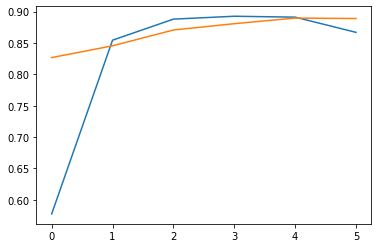

In [278]:
plt.plot(res)
plt.plot(res2)

Видим, что оптимальное learning_rate равно 0.1 для mse и 0.2 для exp.

Подберем max_depths.

In [279]:
depths = [2, 3, 4, 5, 6, 7]
res = []
res2 = []
for d in depths:
    my_clf = MyGradientBoostingClassifier(n_estimators=100, max_depth=d, learning_rate=0.1)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_val)
    res.append(accuracy_score(y_pred=y_pred, y_true=y_val))
    
    clf = MyGradientBoostingClassifier(loss = 'exp', n_estimators=100, max_depth=d, learning_rate=0.2)
    clf.fit(X_train, y1_train)
    y_pred = clf.predict(X_val)
    res2.append(accuracy_score(y_pred=y_pred, y_true=y1_val))

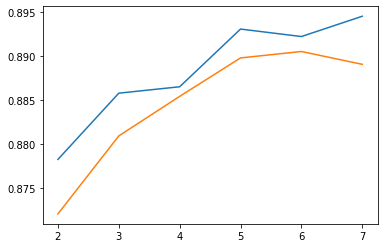

In [280]:
plt.plot(depths, res)
plt.plot(depths, res2)

Оптимальная глубина дерева равна 5.

Подберем colsample и subsample.

In [283]:
cols = [0.25, 0.5, 0.75, 1.0]
subs = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]
res = {}
res2 = {}
for col in cols:
    res['col={}'.format(col)] = []
    res2['col={}'.format(col)] = []
    for sub in subs:
        my_clf = MyGradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                              subsample=sub, colsample=col)
        my_clf.fit(X_train, y_train)
        y_pred = my_clf.predict(X_val)
        res['col={}'.format(col)].append(accuracy_score(y_pred=y_pred, y_true=y_val))
        
        clf = MyGradientBoostingClassifier(loss = 'exp', n_estimators=100, max_depth=5, learning_rate=0.2,
                                           subsample=sub, colsample=col)
        clf.fit(X_train, y1_train)
        y_pred = clf.predict(X_val)
        res2['col={}'.format(col)].append(accuracy_score(y_pred=y_pred, y_true=y1_val))
        
        
res = pd.DataFrame(res)
res2 = pd.DataFrame(res2)

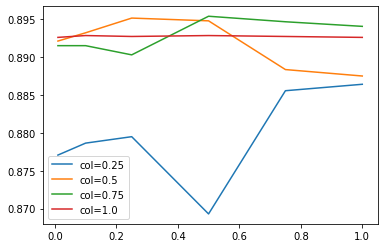

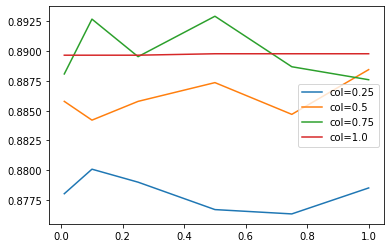

In [284]:
plt.plot(subs, res)
plt.legend(res)
plt.show()

plt.plot(subs, res2)
plt.legend(res2)
plt.show()

Оптимальные параметры:

* n_estimators = 100
* learning_rate = 0.1 (0.2 для exp)
* max_depth = 5
* colsample = 0.75
* subsample = 0.5

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [294]:
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier

In [288]:
X, y = fetch_california_housing(return_X_y=True)

y = (y > 2.0).astype(int)
print(X.shape, y.shape)

idx = np.arange(X.shape[0])
np.random.shuffle(idx)
train_len = int(0.6 * X.shape[0])
X_train, X_val = X[idx[:train_len]], X[idx[train_len:]]
y_train, y_val = y[idx[:train_len]], y[idx[train_len:]]
y1_train, y1_val = y1[idx[:train_len]], y1[idx[train_len:]]

(20640, 8) (20640,)


Boosting of Bagging. Попробуем на mse.

In [289]:
params = { 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y_train, base_model=RandomForestRegressor)
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y_val))

0.8924418604651163


А теперь на exp.

In [291]:
params = { 'loss': 'exp', 'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y1_train, base_model=RandomForestRegressor)
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y1_val))

0.8859011627906976


Ну и на logexp.

In [292]:
params = { 'loss': 'logexp', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y1_train, base_model=RandomForestRegressor)
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y1_val))

0.8654312015503876


Качество улучшить не получилось. Возможно, потому что внутри Boosting классификатора мы уже использовали случайное подмножество фичей и при подобранных параметрах метод уже сходился. Качество даже немного ухудшилось, возможно, мы успели переобучиться.

Bagging of Boosting.

In [307]:
params = { 'loss': 'mse', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
N = 21
pred = np.zeros(X_val.shape[0])
for i in range(N):
    idx = np.random.choice(X_train.shape[0], X_train.shape[0])
    X_bagg, y_bagg = X_train[idx], y_train[idx]
    clf = MyGradientBoostingClassifier(**params)
    clf.fit(X_bagg, y_bagg)
    pred += clf.predict(X_val)
y_pred = (pred > N / 2).astype('int')
print(accuracy_score(y_pred=y_pred, y_true=y_val))

0.890140503875969


In [308]:
params = { 'loss': 'logexp', 'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
N = 21
pred = np.zeros(X_val.shape[0])
for i in range(N):
    idx = np.random.choice(X_train.shape[0], X_train.shape[0])
    X_bagg, y_bagg = X_train[idx], y1_train[idx]
    clf = MyGradientBoostingClassifier(**params)
    clf.fit(X_bagg, y_bagg)
    pred += clf.predict(X_val)
y_pred = -1 + 2 * (pred > 0).astype('int')
print(accuracy_score(y_pred=y_pred, y_true=y1_val))

0.8705184108527132


In [309]:
params = { 'loss': 'exp', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
N = 21
pred = np.zeros(X_val.shape[0])
for i in range(N):
    idx = np.random.choice(X_train.shape[0], X_train.shape[0])
    X_bagg, y_bagg = X_train[idx], y1_train[idx]
    clf = MyGradientBoostingClassifier(**params)
    clf.fit(X_bagg, y_bagg)
    pred += clf.predict(X_val)
y_pred = -1 + 2 * (pred > 0).astype('int')
print(accuracy_score(y_pred=y_pred, y_true=y1_val))

0.8798449612403101


Качество не увеличилось :( Наш бустинг и так берет случайную выборку из всей и усредняет, в какой-то степени, результаты работы базовых алгоритмов.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [324]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [330]:
params = { 'loss': 'mse', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y_train, init_model=make_pipeline(StandardScaler(),LinearRegression()))
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y_val))

0.893047480620155


In [331]:
params = { 'loss': 'mse', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y_train, init_model=make_pipeline(StandardScaler(), LogisticRegression()))
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y_val))

0.8582848837209303


In [333]:
params = { 'loss': 'mse', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y_train, init_model=DecisionTreeRegressor())
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y_val))

0.8338178294573644


In [336]:
params = { 'loss': 'mse', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y_train, init_model=RandomForestRegressor())
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y_val))

0.8785125968992248


In [339]:
params = { 'loss': 'logexp', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y1_train, init_model=make_pipeline(StandardScaler(), SVC()))
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y1_val))

0.8565891472868217


In [340]:
params = { 'loss': 'exp', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y1_train, init_model=make_pipeline(StandardScaler(), SVC()))
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y1_val))

0.8621608527131783


In [341]:
params = { 'loss': 'mse', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'colsample': 0.75, 'subsample': 0.5 }
clf = MyGradientBoostingClassifier(**params)
clf.fit(X_train, y_train, init_model=make_pipeline(StandardScaler(), SVC()))
y_pred = clf.predict(X_val)
print(accuracy_score(y_pred=y_pred, y_true=y_val))

0.8585271317829457


Удалось немного увеличить качество!!! При инициализации линейной регрессией и mse.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Всё понятно вроде :) Немного запутался в BooBag и BagBoo

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Мне понравилась эта домашка, она была интересной, не очень долгой и последовательной.

Отзыв о курсе я писал в одном из последних отзывов на занятие :)